In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
import time
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to C:\Users\mariam
[nltk_data]     walid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\mariam
[nltk_data]     walid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\mariam
[nltk_data]     walid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mariam walid\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Data Loading & Initial Exploration

In [3]:
df = pd.read_csv('bbc_news.csv')

print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic statistics:")
print(df.describe(include='all'))

Dataset shape: (42115, 5)

Column names:
['title', 'pubDate', 'guid', 'link', 'description']

First few rows:
                                               title  \
0  Ukraine: Angry Zelensky vows to punish Russian...   
1  War in Ukraine: Taking cover in a town under a...   
2         Ukraine war 'catastrophic for global food'   
3  Manchester Arena bombing: Saffie Roussos's par...   
4  Ukraine conflict: Oil price soars to highest l...   

                         pubDate  \
0  Mon, 07 Mar 2022 08:01:56 GMT   
1  Sun, 06 Mar 2022 22:49:58 GMT   
2  Mon, 07 Mar 2022 00:14:42 GMT   
3  Mon, 07 Mar 2022 00:05:40 GMT   
4  Mon, 07 Mar 2022 08:15:53 GMT   

                                               guid  \
0  https://www.bbc.co.uk/news/world-europe-60638042   
1  https://www.bbc.co.uk/news/world-europe-60641873   
2      https://www.bbc.co.uk/news/business-60623941   
3            https://www.bbc.co.uk/news/uk-60579079   
4      https://www.bbc.co.uk/news/business-60642786   

     

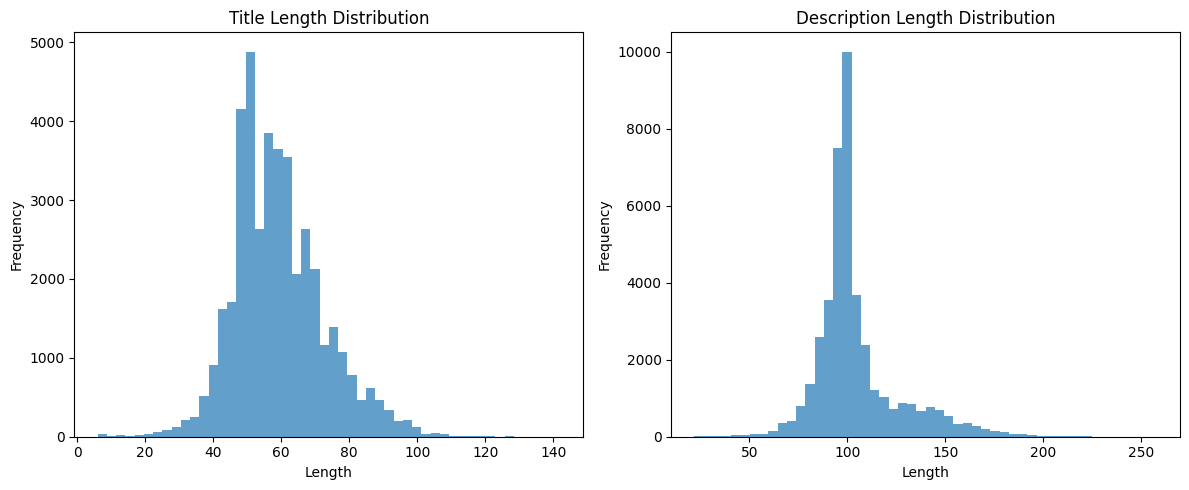

In [4]:
df['title_length'] = df['title'].str.len()
df['description_length'] = df['description'].str.len()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['title_length'].dropna(), bins=50, alpha=0.7)
plt.title('Title Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['description_length'].dropna(), bins=50, alpha=0.7)
plt.title('Description Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [5]:
print("\nSample articles:")
for i in range(3):
    print(f"\nArticle {i+1}:")
    print(f"Title: {df.iloc[i]['title']}")
    print(f"Description: {df.iloc[i]['description']}")


Sample articles:

Article 1:
Title: Ukraine: Angry Zelensky vows to punish Russian atrocities
Description: The Ukrainian president says the country will not forgive or forget those who murder its civilians.

Article 2:
Title: War in Ukraine: Taking cover in a town under attack
Description: Jeremy Bowen was on the frontline in Irpin, as residents came under Russian fire while trying to flee.

Article 3:
Title: Ukraine war 'catastrophic for global food'
Description: One of the world's biggest fertiliser firms says the conflict could deliver a shock to food supplies.


# Text Preprocessing and Data Cleaning

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

custom_stopwords = {
    'bbc', 'news', 'says', 'said', 'mr', 'ms', 'mrs', 'dr', 'prof',
    'http', 'https', 'www', 'com', 'co', 'uk', 'html', 'amp',
    'one', 'two', 'three', 'first', 'second', 'third', 'new', 'old',
    'get', 'got', 'go', 'going', 'gone', 'come', 'came', 'take', 'taken',
    'make', 'made', 'way', 'time', 'year', 'day', 'week', 'month'
}
stop_words.update(custom_stopwords)

In [7]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    text = text.lower()
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)


In [8]:
print("Creating combined text from title and description...")
df['combined_text'] = df['title'].fillna('') + '. ' + df['description'].fillna('')

print(f"Original dataset size: {len(df)}")
df_clean = df.drop_duplicates(subset=['title', 'description'])
print(f"After removing duplicates: {len(df_clean)}")

print("Preprocessing text... This may take a few minutes...")
df_clean['processed_text'] = df_clean['combined_text'].apply(preprocess_text)

df_clean['word_count'] = df_clean['processed_text'].apply(lambda x: len(x.split()))
df_final = df_clean[df_clean['word_count'] >= 3].copy()

print(f"Final dataset size after preprocessing: {len(df_final)}")

Creating combined text from title and description...
Original dataset size: 42115
After removing duplicates: 40111
Preprocessing text... This may take a few minutes...
Final dataset size after preprocessing: 40111


In [9]:
print("\nPreprocessing examples:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original: {df_final.iloc[i]['combined_text']}")
    print(f"Processed: {df_final.iloc[i]['processed_text']}")
    print(f"Word count: {df_final.iloc[i]['word_count']}")


Preprocessing examples:

Example 1:
Original: Ukraine: Angry Zelensky vows to punish Russian atrocities. The Ukrainian president says the country will not forgive or forget those who murder its civilians.
Processed: ukraine angry zelensky vow punish russian atrocity ukrainian president country forgive forget murder civilian
Word count: 14

Example 2:
Original: War in Ukraine: Taking cover in a town under attack. Jeremy Bowen was on the frontline in Irpin, as residents came under Russian fire while trying to flee.
Processed: war ukraine taking cover town attack jeremy bowen frontline irpin resident russian fire trying flee
Word count: 15

Example 3:
Original: Ukraine war 'catastrophic for global food'. One of the world's biggest fertiliser firms says the conflict could deliver a shock to food supplies.
Processed: ukraine war catastrophic global food world biggest fertiliser firm conflict could deliver shock food supply
Word count: 15


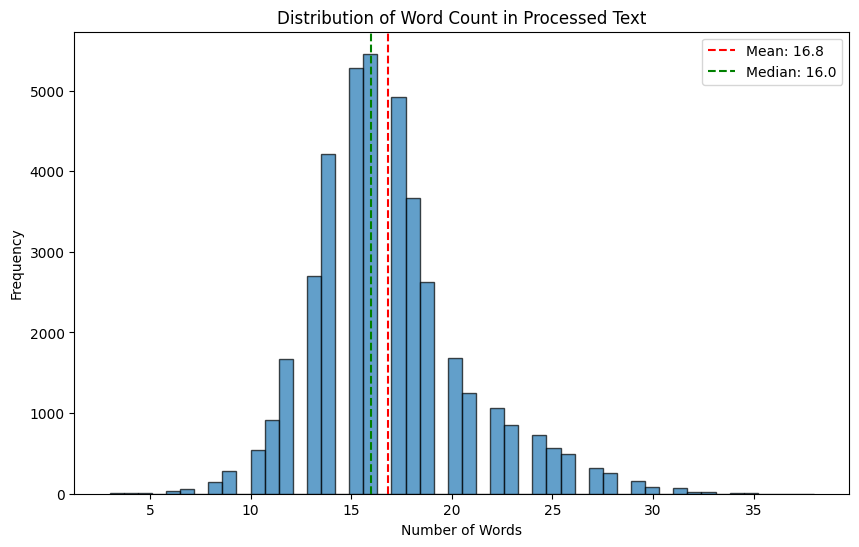

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(df_final['word_count'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Word Count in Processed Text')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(df_final['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df_final["word_count"].mean():.1f}')
plt.axvline(df_final['word_count'].median(), color='green', linestyle='--', label=f'Median: {df_final["word_count"].median():.1f}')
plt.legend()
plt.show()

In [11]:
print(f"\nWord count statistics:")
print(f"Mean: {df_final['word_count'].mean():.1f}")
print(f"Median: {df_final['word_count'].median():.1f}")
print(f"Min: {df_final['word_count'].min()}")
print(f"Max: {df_final['word_count'].max()}")


Word count statistics:
Mean: 16.8
Median: 16.0
Min: 3
Max: 38


# Feature Engineering (Vectorization)

In [12]:
print("Creating document-term matrix...")

vectorizer = CountVectorizer(
    max_features=5000,      
    min_df=5,             
    max_df=0.7,           
    ngram_range=(1, 2),   
    token_pattern=r'\b[a-zA-Z][a-zA-Z]+\b' 
)

Creating document-term matrix...


In [13]:
doc_term_matrix = vectorizer.fit_transform(df_final['processed_text'])
feature_names = vectorizer.get_feature_names_out()

print(f"Document-term matrix shape: {doc_term_matrix.shape}")
print(f"Number of documents: {doc_term_matrix.shape[0]}")
print(f"Vocabulary size: {doc_term_matrix.shape[1]}")
print(f"Sparsity: {(1 - doc_term_matrix.nnz / (doc_term_matrix.shape[0] * doc_term_matrix.shape[1])) * 100:.2f}%")

print(f"\nVocabulary analysis:")
print(f"Sample words from vocabulary:")
print(feature_names[:20])
print(f"\n")
print(feature_names[-20:])

Document-term matrix shape: (40111, 5000)
Number of documents: 40111
Vocabulary size: 5000
Sparsity: 99.74%

Vocabulary analysis:
Sample words from vocabulary:
['aaron' 'abandoned' 'abbey' 'abbott' 'abdul' 'aberdeen' 'ability' 'able'
 'abortion' 'abroad' 'absence' 'absolutely' 'abuse' 'abused' 'abusive'
 'academy' 'accept' 'accepted' 'access' 'accident']


['young' 'young people' 'younger' 'youngest' 'yousaf' 'youth' 'youtube'
 'youtuber' 'zaghari' 'zaghari ratcliffe' 'zahawi' 'zaporizhzhia' 'zara'
 'zealand' 'zelensky' 'zero' 'zoe' 'zoe conway' 'zone' 'zoo']


In [14]:
word_freq = np.array(doc_term_matrix.sum(axis=0)).flatten()
word_freq_df = pd.DataFrame({
    'word': feature_names,
    'frequency': word_freq
}).sort_values('frequency', ascending=False)

print(f"\nTop 20 most frequent words:")
print(word_freq_df.head(20))

print(f"\nTop 20 least frequent words:")
print(word_freq_df.tail(20))


Top 20 most frequent words:
            word  frequency
4932       world       3918
1407     england       3896
1022         cup       2884
4885         win       2781
4650     ukraine       2578
4915       woman       2547
1628       final       2353
3206      people       2263
4937   world cup       2050
2494      league       1999
3859         say       1956
4788         war       1873
3300      police       1846
772         city       1742
2676         man       1718
949        could       1570
4972        year       1520
4037        show       1478
2057        home       1453
2688  manchester       1406

Top 20 least frequent words:
                     word  frequency
262            assaulting         25
1358      election debate         25
2925           nat sciver         25
2897               mumbai         25
2899                mural         25
4525                toney         25
1629         final defeat         25
1566                farah         25
4441            temp

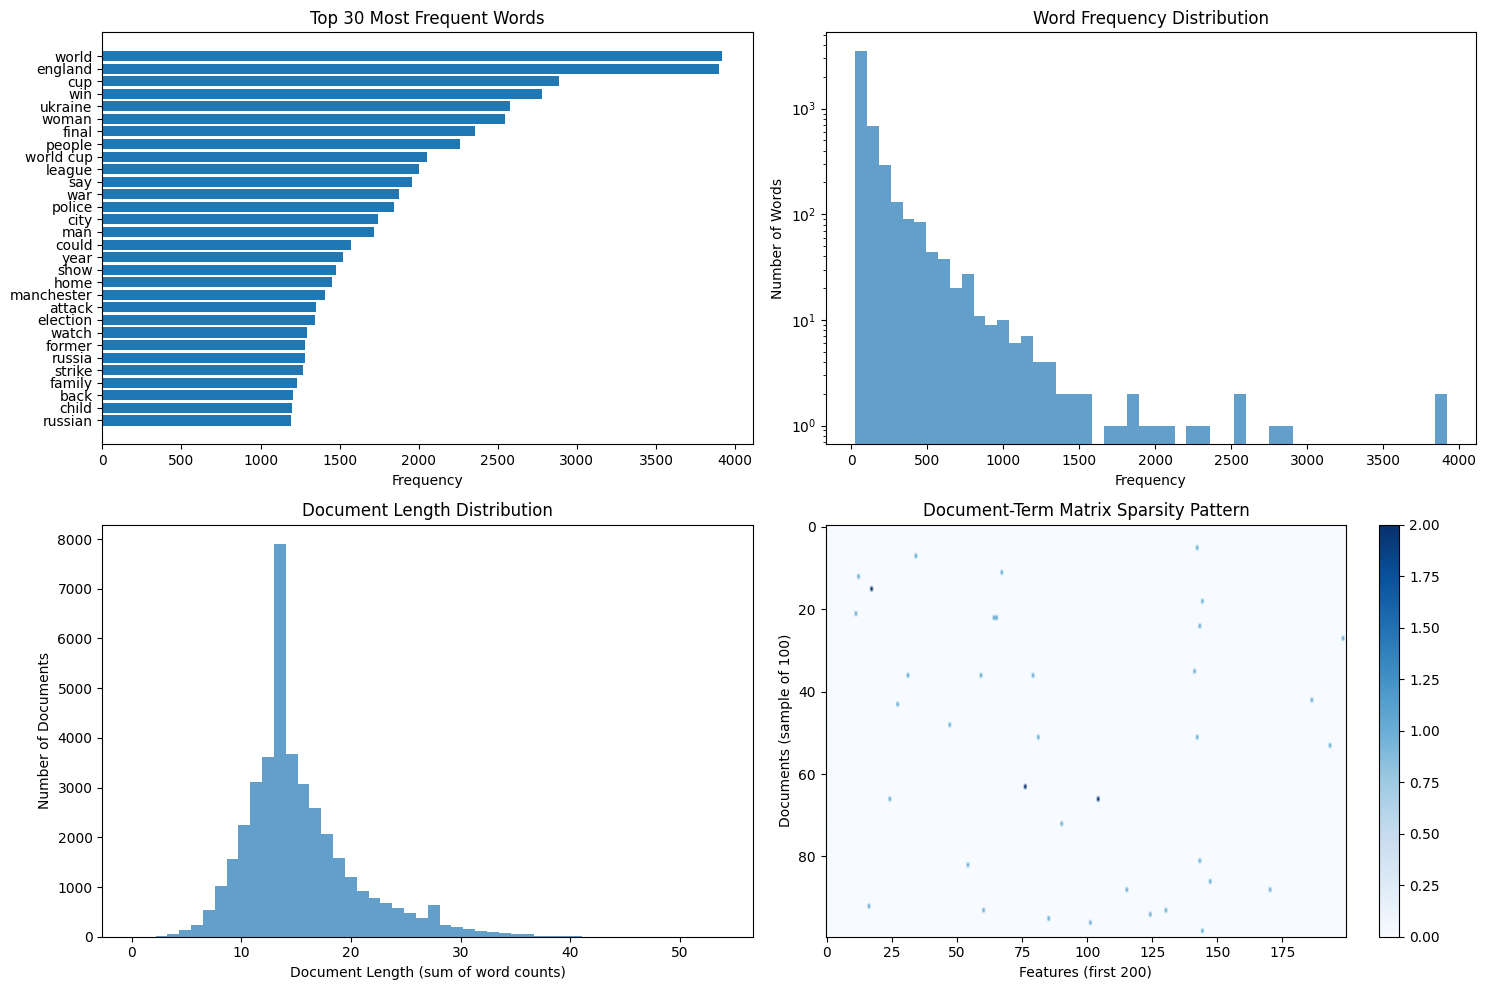

In [15]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
top_words = word_freq_df.head(30)
plt.barh(range(len(top_words)), top_words['frequency'])
plt.yticks(range(len(top_words)), top_words['word'])
plt.xlabel('Frequency')
plt.title('Top 30 Most Frequent Words')
plt.gca().invert_yaxis()

plt.subplot(2, 2, 2)
plt.hist(word_freq_df['frequency'], bins=50, alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Number of Words')
plt.title('Word Frequency Distribution')
plt.yscale('log')

doc_lengths = np.array(doc_term_matrix.sum(axis=1)).flatten()
plt.subplot(2, 2, 3)
plt.hist(doc_lengths, bins=50, alpha=0.7)
plt.xlabel('Document Length (sum of word counts)')
plt.ylabel('Number of Documents')
plt.title('Document Length Distribution')

plt.subplot(2, 2, 4)
sample_size = min(100, doc_term_matrix.shape[0])
sample_indices = np.random.choice(doc_term_matrix.shape[0], sample_size, replace=False)
sample_matrix = doc_term_matrix[sample_indices, :200].toarray() 
plt.imshow(sample_matrix, cmap='Blues', aspect='auto')
plt.xlabel('Features (first 200)')
plt.ylabel('Documents (sample of 100)')
plt.title('Document-Term Matrix Sparsity Pattern')
plt.colorbar()

plt.tight_layout()
plt.show()

In [16]:
print(f"\nMatrix statistics:")
print(f"Mean document length: {doc_lengths.mean():.2f}")
print(f"Median document length: {np.median(doc_lengths):.2f}")
print(f"Standard deviation: {doc_lengths.std():.2f}")


Matrix statistics:
Mean document length: 15.29
Median document length: 14.00
Standard deviation: 5.21


In [17]:
empty_docs = np.where(doc_lengths == 0)[0]
if len(empty_docs) > 0:
    print(f"\nWarning: {len(empty_docs)} documents became empty after vectorization")
    print("Sample empty documents:")
    for i in empty_docs[:3]:
        print(f"  Original: {df_final.iloc[i]['combined_text']}")
        print(f"  Processed: {df_final.iloc[i]['processed_text']}")
else:
    print(f"\nGood: No documents became empty after vectorization")


Sample empty documents:
  Original: Are we being tricked by our fitness trackers?. How accurate are fitness trackers?
  Processed: tricked fitness tracker accurate fitness tracker


# LDA Model Training and Optimization

In [18]:
non_empty_mask = np.array(doc_term_matrix.sum(axis=1)).flatten() > 0
doc_term_matrix_clean = doc_term_matrix[non_empty_mask]
df_model = df_final[non_empty_mask].copy()

print(f"Documents after removing empty ones: {doc_term_matrix_clean.shape[0]}")

Documents after removing empty ones: 40110


In [19]:
def evaluate_lda_model(n_topics, doc_term_matrix, random_state=42):
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=10,
        learning_method='online',
        learning_offset=50.0,
        random_state=random_state,
        n_jobs=-1
    )
    
    lda.fit(doc_term_matrix)
    log_likelihood = lda.score(doc_term_matrix)
    perplexity = lda.perplexity(doc_term_matrix)
    return lda, log_likelihood, perplexity

topic_range = range(5, 21, 2)
print("Testing different numbers of topics...")

results = []
models = {}

for n_topics in topic_range:
    print(f"Training LDA with {n_topics} topics...")
    start_time = time.time()
    lda_model, log_likelihood, perplexity = evaluate_lda_model(n_topics, doc_term_matrix_clean)
    end_time = time.time()
    results.append({
        'n_topics': n_topics,
        'log_likelihood': log_likelihood,
        'perplexity': perplexity,
        'training_time': end_time - start_time
    })
    models[n_topics] = lda_model
    print(f"  Topics: {n_topics}, Log-likelihood: {log_likelihood:.2f}, "f"Perplexity: {perplexity:.2f}, Time: {end_time - start_time:.2f}s")

Testing different numbers of topics...
Training LDA with 5 topics...
  Topics: 5, Log-likelihood: -4711213.98, Perplexity: 2163.68, Time: 110.00s
Training LDA with 7 topics...
  Topics: 7, Log-likelihood: -4712446.40, Perplexity: 2168.03, Time: 111.28s
Training LDA with 9 topics...
  Topics: 9, Log-likelihood: -4737378.11, Perplexity: 2257.96, Time: 113.37s
Training LDA with 11 topics...
  Topics: 11, Log-likelihood: -4766256.98, Perplexity: 2366.79, Time: 121.85s
Training LDA with 13 topics...
  Topics: 13, Log-likelihood: -4769364.32, Perplexity: 2378.81, Time: 130.92s
Training LDA with 15 topics...
  Topics: 15, Log-likelihood: -4786840.31, Perplexity: 2447.55, Time: 134.35s
Training LDA with 17 topics...
  Topics: 17, Log-likelihood: -4792066.84, Perplexity: 2468.49, Time: 144.76s
Training LDA with 19 topics...
  Topics: 19, Log-likelihood: -4793623.25, Perplexity: 2474.76, Time: 157.83s


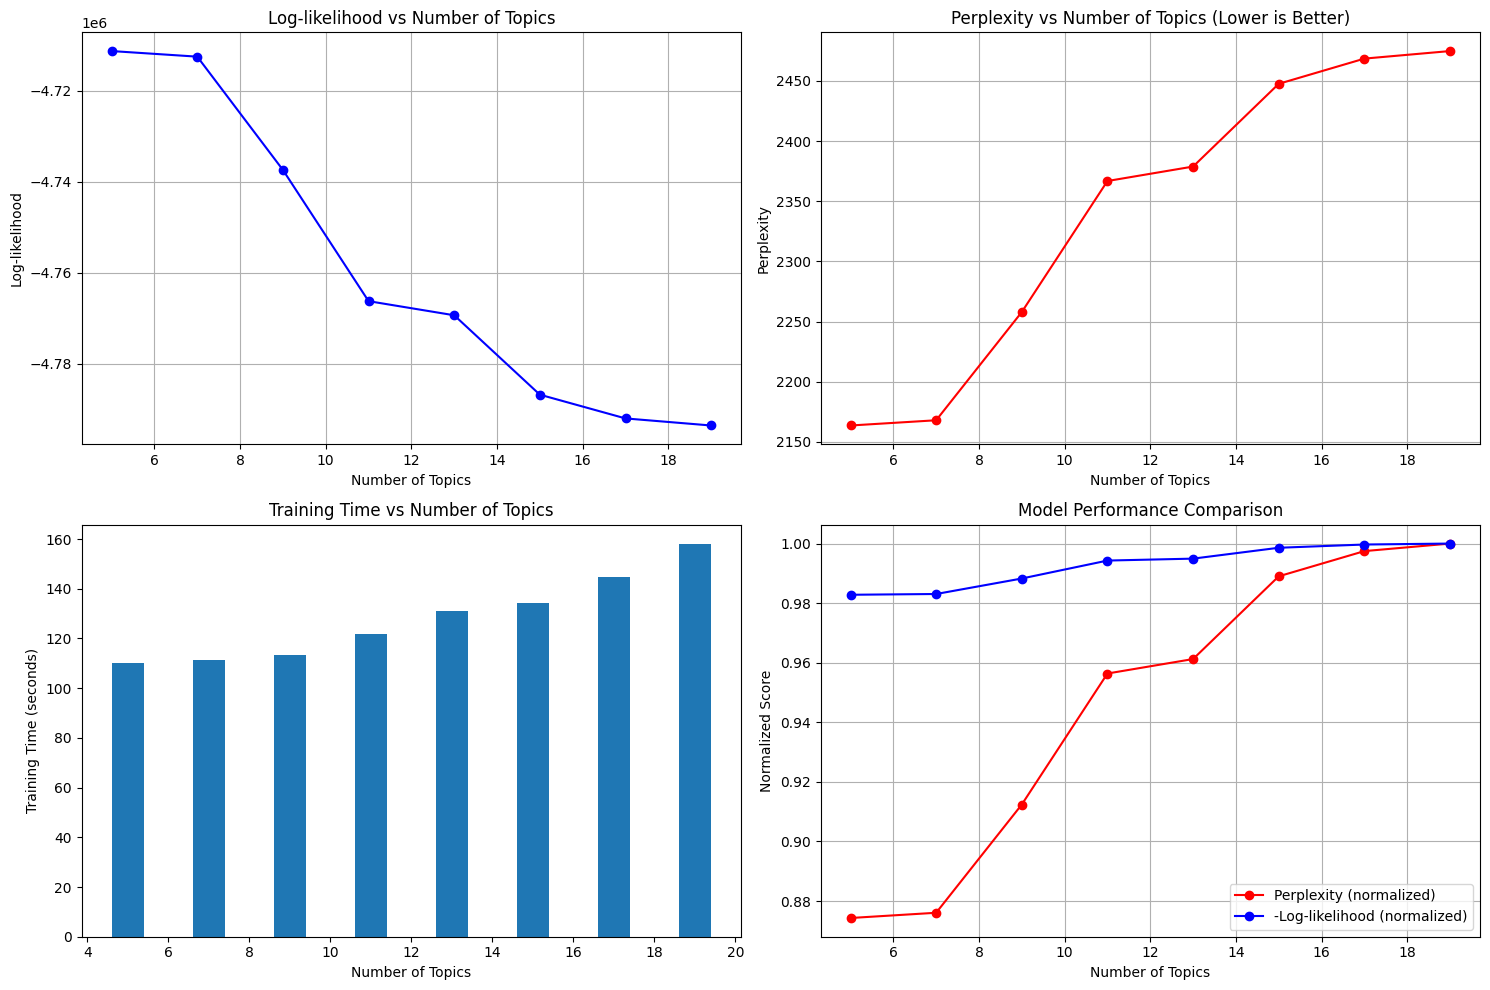

In [20]:
results_df = pd.DataFrame(results)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(results_df['n_topics'], results_df['log_likelihood'], 'bo-')
axes[0, 0].set_xlabel('Number of Topics')
axes[0, 0].set_ylabel('Log-likelihood')
axes[0, 0].set_title('Log-likelihood vs Number of Topics')
axes[0, 0].grid(True)

axes[0, 1].plot(results_df['n_topics'], results_df['perplexity'], 'ro-')
axes[0, 1].set_xlabel('Number of Topics')
axes[0, 1].set_ylabel('Perplexity')
axes[0, 1].set_title('Perplexity vs Number of Topics (Lower is Better)')
axes[0, 1].grid(True)

axes[1, 0].bar(results_df['n_topics'], results_df['training_time'])
axes[1, 0].set_xlabel('Number of Topics')
axes[1, 0].set_ylabel('Training Time (seconds)')
axes[1, 0].set_title('Training Time vs Number of Topics')

axes[1, 1].plot(results_df['n_topics'], results_df['perplexity'] / results_df['perplexity'].max(), 'ro-', label='Perplexity (normalized)')
axes[1, 1].plot(results_df['n_topics'], -results_df['log_likelihood'] / (-results_df['log_likelihood']).max(), 'bo-', label='-Log-likelihood (normalized)')
axes[1, 1].set_xlabel('Number of Topics')
axes[1, 1].set_ylabel('Normalized Score')
axes[1, 1].set_title('Model Performance Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [21]:
optimal_topics = results_df.loc[results_df['perplexity'].idxmin(), 'n_topics']
print(f"\nOptimal number of topics based on perplexity: {optimal_topics}")

print(f"\nModel evaluation results:")
print(results_df.round(2))


Optimal number of topics based on perplexity: 5

Model evaluation results:
   n_topics  log_likelihood  perplexity  training_time
0         5     -4711213.98     2163.68         110.00
1         7     -4712446.40     2168.03         111.28
2         9     -4737378.11     2257.96         113.37
3        11     -4766256.98     2366.79         121.85
4        13     -4769364.32     2378.81         130.92
5        15     -4786840.31     2447.55         134.35
6        17     -4792066.84     2468.49         144.76
7        19     -4793623.25     2474.76         157.83


In [22]:
print(f"\nTraining final LDA model with {optimal_topics} topics...")
final_lda = LatentDirichletAllocation(
    n_components=optimal_topics,
    max_iter=20,  
    learning_method='online',
    learning_offset=50.0,
    random_state=42,
    n_jobs=-1
)
final_lda.fit(doc_term_matrix_clean)
print(f"Final model training completed!")
print(f"Final perplexity: {final_lda.perplexity(doc_term_matrix_clean):.2f}")
print(f"Final log-likelihood: {final_lda.score(doc_term_matrix_clean):.2f}")


Training final LDA model with 5 topics...
Final model training completed!
Final perplexity: 2153.03
Final log-likelihood: -4708185.56


In [23]:
def display_topics(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
        print(f"Topic {topic_idx}: {', '.join(top_words)}")
    return topics

print(f"\nPreview of topics (top 10 words per topic):")
topic_words = display_topics(final_lda, feature_names, 10)


Preview of topics (top 10 words per topic):
Topic 0: could, government, minister, people, plan, labour, cost, leader, party, court
Topic 1: league, star, win, trump, premier, liverpool, premier league, queen, champion, chelsea
Topic 2: world, england, cup, final, world cup, win, woman, open, team, player
Topic 3: ukraine, police, war, attack, death, russia, israel, woman, say, gaza
Topic 4: manchester, city, paper, election, man, show, day, fire, manchester united, israeli


# Topic Analysis and Interpretation

In [24]:
print(" DETAILED TOPIC ANALYSIS ")

def get_topic_details(lda_model, feature_names, n_words=20):
    topics_data = []
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[-n_words:][::-1]
        top_words = [(feature_names[i], topic[i]) for i in top_words_idx]
        
        topics_data.append({
            'topic_id': topic_idx,
            'words_probs': top_words,
            'topic_sum': topic.sum()
        })
    
    return topics_data

topic_details = get_topic_details(final_lda, feature_names, 20)

for i, topic_data in enumerate(topic_details):
    print(f"\n TOPIC {i} ")
    print("Top 20 words with probabilities:")
    for word, prob in topic_data['words_probs']:
        print(f"  {word:15} {prob:8.1f}")

 DETAILED TOPIC ANALYSIS 

 TOPIC 0 
Top 20 words with probabilities:
  could             1495.5
  government        1181.2
  minister          1131.1
  people             971.4
  plan               937.0
  labour             929.2
  cost               863.9
  leader             845.2
  party              820.6
  court              814.8
  change             784.3
  say                778.4
  strike             751.6
  sunak              723.4
  rise               683.2
  cut                658.3
  tory               646.2
  pay                638.4
  next               626.2
  former             625.8

 TOPIC 1 
Top 20 words with probabilities:
  league            1923.9
  star              1073.5
  win               1040.4
  trump              975.8
  premier            807.9
  liverpool          798.9
  premier league     790.1
  queen              646.9
  champion           644.2
  chelsea            593.7
  united             568.0
  last               549.1
  fan                5

In [25]:
print("\n DOCUMENT-TOPIC ANALYSIS ")

doc_topic_probs = final_lda.transform(doc_term_matrix_clean)
topic_columns = [f'Topic_{i}' for i in range(final_lda.n_components)]
doc_topic_df = pd.DataFrame(doc_topic_probs, columns=topic_columns)
doc_topic_df['title'] = df_model['title'].values
doc_topic_df['description'] = df_model['description'].values
doc_topic_df['combined_text'] = df_model['combined_text'].values
doc_topic_df['dominant_topic'] = doc_topic_probs.argmax(axis=1)
doc_topic_df['max_probability'] = doc_topic_probs.max(axis=1)

print(f"Document-Topic Distribution Summary:")
print(f"Mean max probability: {doc_topic_df['max_probability'].mean():.3f}")
print(f"Median max probability: {doc_topic_df['max_probability'].median():.3f}")
print(f"Documents with high confidence (>0.5): {(doc_topic_df['max_probability'] > 0.5).sum():,}")


 DOCUMENT-TOPIC ANALYSIS 
Document-Topic Distribution Summary:
Mean max probability: 0.623
Median max probability: 0.603
Documents with high confidence (>0.5): 28,867


In [26]:
topic_counts = doc_topic_df['dominant_topic'].value_counts().sort_index()
print(f"\nDocument count per topic:")
for topic_id, count in topic_counts.items():
    percentage = (count / len(doc_topic_df)) * 100
    print(f"  Topic {topic_id}: {count:5,} documents ({percentage:5.1f}%)")


Document count per topic:
  Topic 0: 13,016 documents ( 32.5%)
  Topic 1: 6,490 documents ( 16.2%)
  Topic 2: 5,419 documents ( 13.5%)
  Topic 3: 10,883 documents ( 27.1%)
  Topic 4: 4,302 documents ( 10.7%)


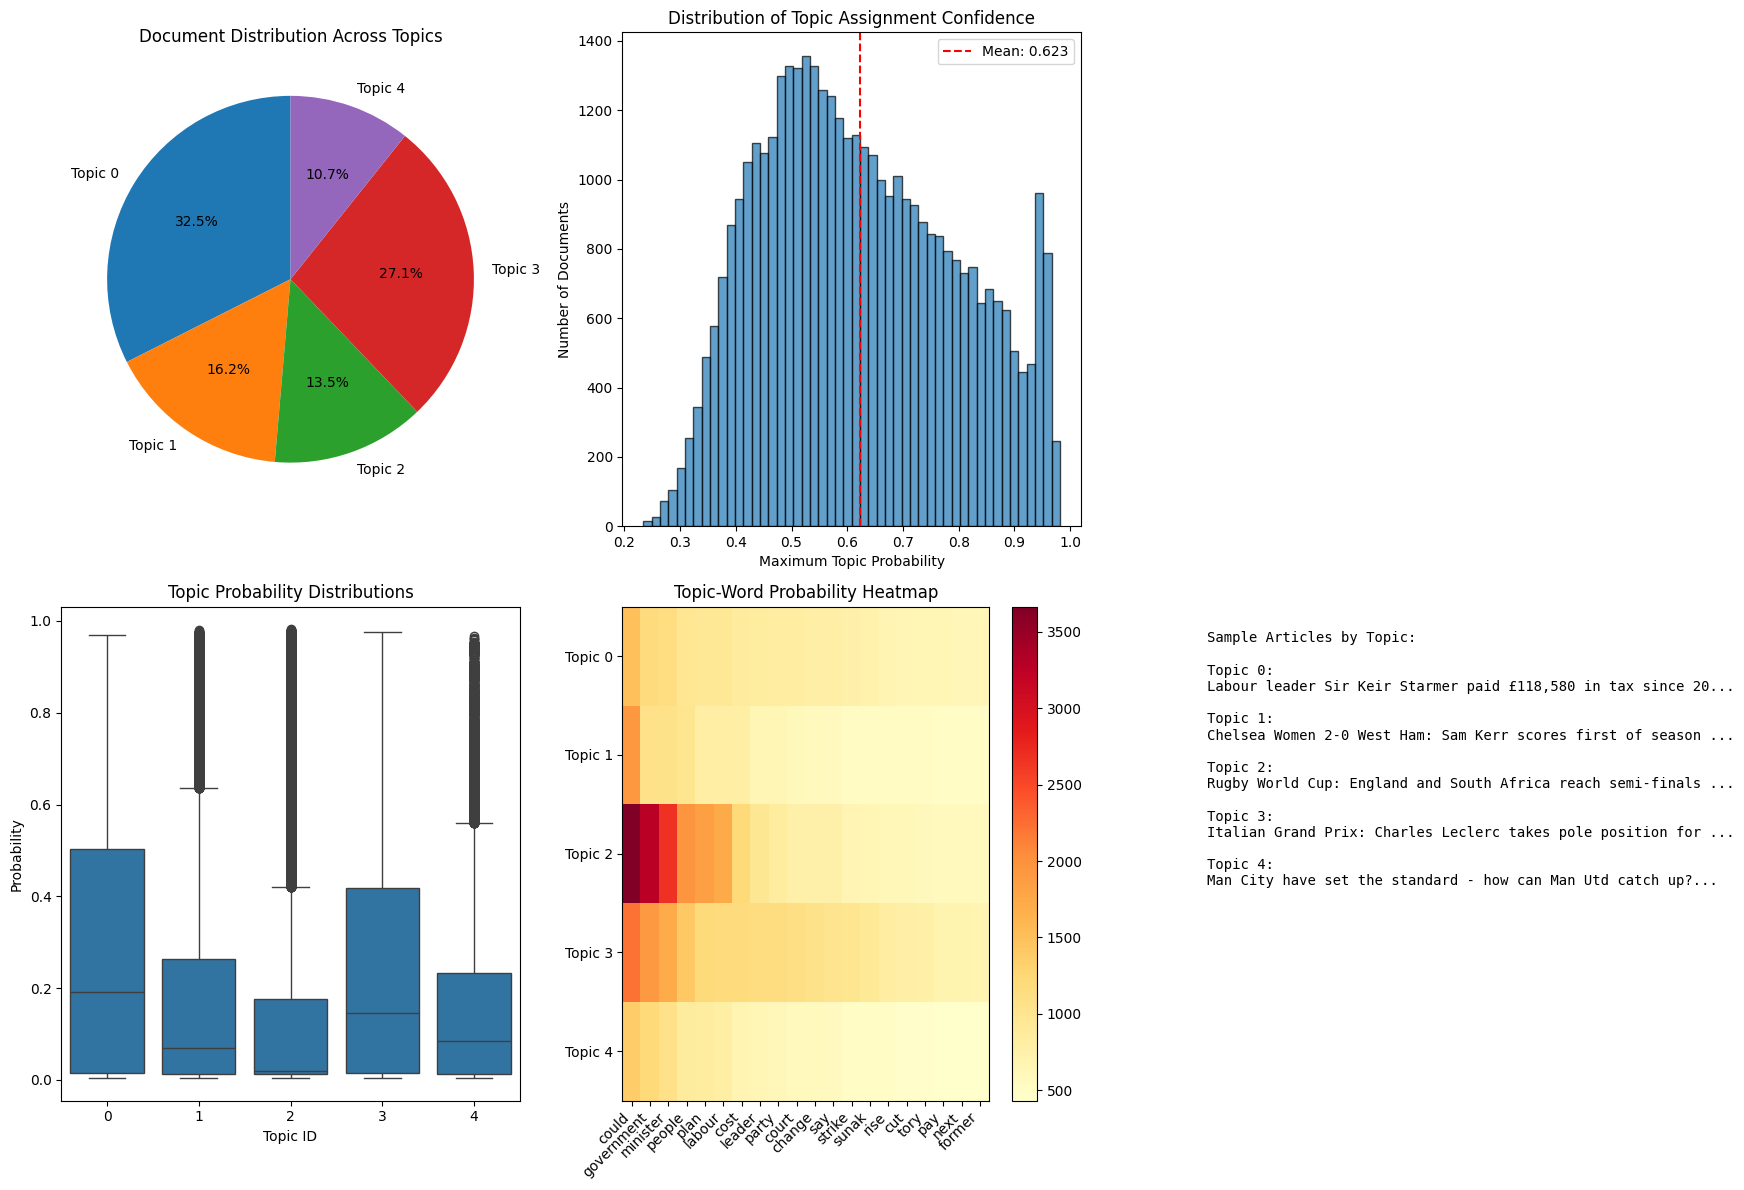

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].pie(topic_counts.values, labels=[f'Topic {i}' for i in topic_counts.index], autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Document Distribution Across Topics')

axes[0, 1].hist(doc_topic_df['max_probability'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Maximum Topic Probability')
axes[0, 1].set_ylabel('Number of Documents')
axes[0, 1].set_title('Distribution of Topic Assignment Confidence')
axes[0, 1].axvline(doc_topic_df['max_probability'].mean(), color='red', linestyle='--', label=f'Mean: {doc_topic_df["max_probability"].mean():.3f}')
axes[0, 1].legend()

top_words_per_topic = []
topic_labels = []
for i, topic_data in enumerate(topic_details):
    words = [word for word, prob in topic_data['words_probs'][:15]]
    top_words_per_topic.extend(words)
    topic_labels.extend([f'Topic {i}'] * 15)
word_topic_matrix = np.zeros((5, 15))  
all_top_words = []
for i, topic_data in enumerate(topic_details):
    topic_words = [word for word, prob in topic_data['words_probs'][:15]]
    all_top_words.append(topic_words)
    
axes[0, 2].axis('off') 

topic_prob_data = []
for i in range(5):
    topic_prob_data.extend([(i, prob) for prob in doc_topic_probs[:, i]])
topic_prob_df = pd.DataFrame(topic_prob_data, columns=['Topic', 'Probability'])
sns.boxplot(data=topic_prob_df, x='Topic', y='Probability', ax=axes[1, 0])
axes[1, 0].set_title('Topic Probability Distributions')
axes[1, 0].set_xlabel('Topic ID')

topic_word_matrix = np.zeros((5, 20))
word_labels = []
for i, topic_data in enumerate(topic_details):
    for j, (word, prob) in enumerate(topic_data['words_probs'][:20]):
        topic_word_matrix[i, j] = prob
        if i == 0: 
            word_labels.append(word)

im = axes[1, 1].imshow(topic_word_matrix, cmap='YlOrRd', aspect='auto')
axes[1, 1].set_xticks(range(20))
axes[1, 1].set_xticklabels(word_labels[:20], rotation=45, ha='right')
axes[1, 1].set_yticks(range(5))
axes[1, 1].set_yticklabels([f'Topic {i}' for i in range(5)])
axes[1, 1].set_title('Topic-Word Probability Heatmap')
plt.colorbar(im, ax=axes[1, 1])

axes[1, 2].axis('off')
sample_text = "Sample Articles by Topic:\n\n"
for topic_id in range(5):
    topic_docs = doc_topic_df[doc_topic_df['dominant_topic'] == topic_id]
    top_doc = topic_docs.loc[topic_docs['max_probability'].idxmax()]
    sample_text += f"Topic {topic_id}:\n{top_doc['title'][:60]}...\n\n"
axes[1, 2].text(0.05, 0.95, sample_text, transform=axes[1, 2].transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

In [28]:
print(f"\n REPRESENTATIVE ARTICLES PER TOPIC ")
for topic_id in range(5):
    print(f"\n TOPIC {topic_id} EXAMPLES ")
    topic_docs = doc_topic_df[doc_topic_df['dominant_topic'] == topic_id]
    top_docs = topic_docs.nlargest(3, 'max_probability')
    
    for idx, (_, doc) in enumerate(top_docs.iterrows()):
        print(f"{idx+1}. (Prob: {doc['max_probability']:.3f}) {doc['title']}")
        print(f"   {doc['description'][:100]}...")


 REPRESENTATIVE ARTICLES PER TOPIC 

 TOPIC 0 EXAMPLES 
1. (Prob: 0.970) Labour leader Sir Keir Starmer paid £118,580 in tax since 2020
   Sir Keir's release comes a day after Prime Minister Rishi Sunak published details of his finances....
2. (Prob: 0.970) Bank of England governor defends rate hike ahead of looming recession
   Bank of England governor Andrew Bailey warns price rises would be long-term if Bank did not act....
3. (Prob: 0.968) Rishi Sunak and Liz Truss row over recession warning in latest TV clash
   Rishi Sunak says tax cuts would fuel inflation, while Liz Truss argues a recession can be averted....

 TOPIC 1 EXAMPLES 
1. (Prob: 0.980) Chelsea Women 2-0 West Ham: Sam Kerr scores first of season as Blues top Women's Super League
   Sam Kerr scores her first goal of the season as reigning Women's Super League champions Chelsea beat...
2. (Prob: 0.978) Chelsea 2-1 Liverpool: Women's Super League title hopes boosted by Sam Kerr winner
   Chelsea's Women's Super League ti

In [29]:
topic_names = [
    "Politics & Government",
    "Sports & Entertainment", 
    "International Sports",
    "Conflicts & Crime",
    "Local News & Events"
]

print(f"\n TOPIC INTERPRETATION SUMMARY ")
for i, name in enumerate(topic_names):
    count = topic_counts[i]
    percentage = (count / len(doc_topic_df)) * 100
    top_words = [word for word, _ in topic_details[i]['words_probs'][:5]]
    print(f"Topic {i}: {name}")
    print(f"  Coverage: {count:,} articles ({percentage:.1f}%)")
    print(f"  Key words: {', '.join(top_words)}")
    print()


 TOPIC INTERPRETATION SUMMARY 
Topic 0: Politics & Government
  Coverage: 13,016 articles (32.5%)
  Key words: could, government, minister, people, plan

Topic 1: Sports & Entertainment
  Coverage: 6,490 articles (16.2%)
  Key words: league, star, win, trump, premier

Topic 2: International Sports
  Coverage: 5,419 articles (13.5%)
  Key words: world, england, cup, final, world cup

Topic 3: Conflicts & Crime
  Coverage: 10,883 articles (27.1%)
  Key words: ukraine, police, war, attack, death

Topic 4: Local News & Events
  Coverage: 4,302 articles (10.7%)
  Key words: manchester, city, paper, election, man



# Interactive Visualization with pyLDAvis

In [30]:
try:
    import pyLDAvis
    import pyLDAvis.lda_model
except ImportError:
    print("Installing pyLDAvis...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pyLDAvis"])
    import pyLDAvis
    import pyLDAvis.lda_model

In [31]:
print(" INTERACTIVE TOPIC VISUALIZATION ")
print("Preparing data for pyLDAvis visualization...")

try:
    pyLDAvis.enable_notebook()
    
    vis_data = pyLDAvis.lda_model.prepare(
        lda_model=final_lda,
        dtm=doc_term_matrix_clean,
        vectorizer=vectorizer,
        mds='tsne', 
        R=20,       
        lambda_step=0.01,
        plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}
    )
    
    print("Generating interactive pyLDAvis visualization...")
    pyLDAvis.display(vis_data)
    
    pyLDAvis.save_html(vis_data, 'bbc_news_topic_model.html')
    print("Interactive visualization saved as 'bbc_news_topic_model.html'")
    
except Exception as e:
    print(f"Error creating pyLDAvis visualization: {e}")
    print("Continuing with alternative visualizations...")

 INTERACTIVE TOPIC VISUALIZATION 
Preparing data for pyLDAvis visualization...
Generating interactive pyLDAvis visualization...
Interactive visualization saved as 'bbc_news_topic_model.html'



Generating word clouds for each topic...


C:\Users\mariam walid\AppData\Roaming\Python\Python310\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
C:\Users\mariam walid\AppData\Roaming\Python\Python310\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
C:\Users\mariam walid\AppData\Roaming\Python\Python310\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __arra

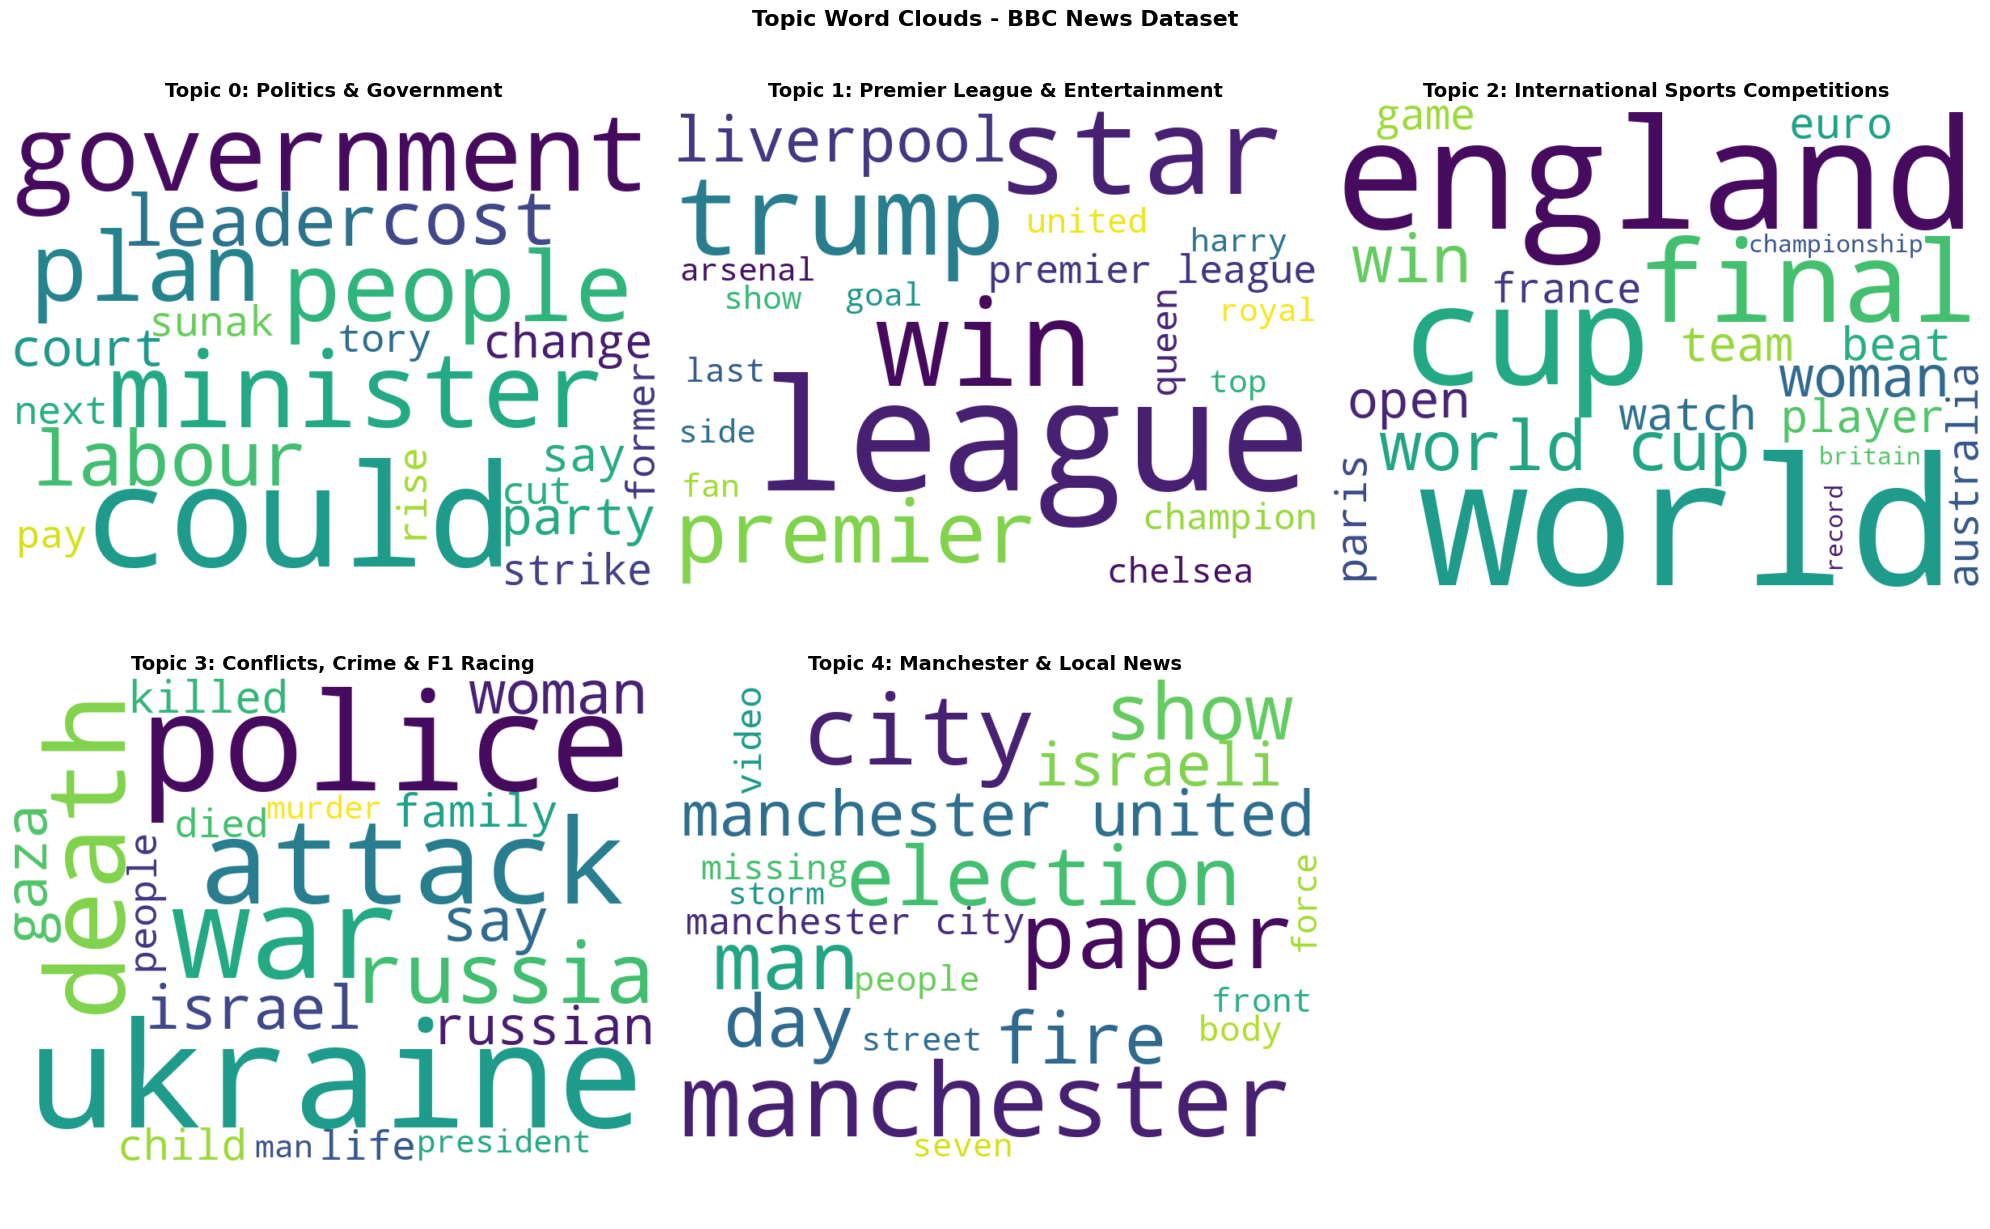

In [32]:
print("\nGenerating word clouds for each topic...")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

topic_names = [
    "Politics & Government",
    "Premier League & Entertainment", 
    "International Sports Competitions",
    "Conflicts, Crime & F1 Racing",
    "Manchester & Local News"
]

for i in range(5):
    topic_words = {}
    for word, prob in topic_details[i]['words_probs'][:30]:
        topic_words[word] = prob
    
    wordcloud = WordCloud(
        width=800, 
        height=600, 
        background_color='white',
        max_words=30,
        colormap='viridis',
        relative_scaling=0.5,
        random_state=42
    ).generate_from_frequencies(topic_words)
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Topic {i}: {topic_names[i]}', fontsize=14, fontweight='bold')
    axes[i].axis('off')

axes[5].axis('off')

plt.tight_layout()
plt.suptitle('Topic Word Clouds - BBC News Dataset', fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [33]:
print("\n TOPIC SIMILARITY ANALYSIS ")

topic_word_matrix = final_lda.components_

topic_similarity = cosine_similarity(topic_word_matrix)


 TOPIC SIMILARITY ANALYSIS 


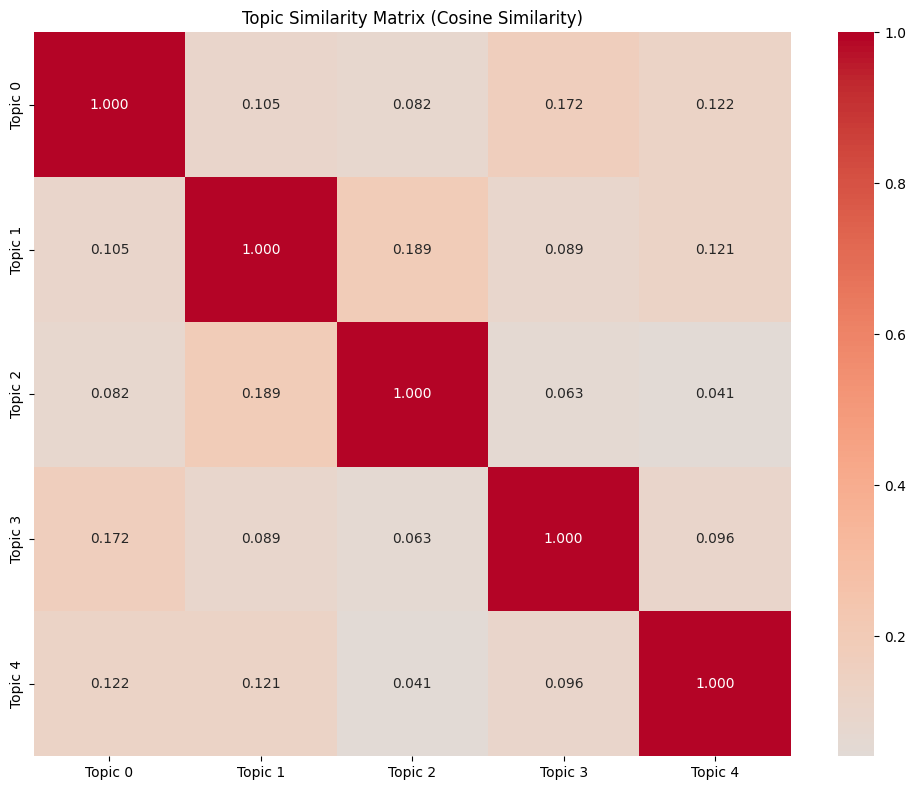

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    topic_similarity, 
    annot=True, 
    cmap='coolwarm', 
    center=0,
    xticklabels=[f'Topic {i}' for i in range(5)],
    yticklabels=[f'Topic {i}' for i in range(5)],
    fmt='.3f'
)
plt.title('Topic Similarity Matrix (Cosine Similarity)')
plt.tight_layout()
plt.show()

In [35]:
print("Topic similarity insights:")
for i in range(5):
    for j in range(i+1, 5):
        similarity = topic_similarity[i, j]
        print(f"Topics {i} and {j}: {similarity:.3f} similarity")

Topic similarity insights:
Topics 0 and 1: 0.105 similarity
Topics 0 and 2: 0.082 similarity
Topics 0 and 3: 0.172 similarity
Topics 0 and 4: 0.122 similarity
Topics 1 and 2: 0.189 similarity
Topics 1 and 3: 0.089 similarity
Topics 1 and 4: 0.121 similarity
Topics 2 and 3: 0.063 similarity
Topics 2 and 4: 0.041 similarity
Topics 3 and 4: 0.096 similarity


In [36]:
print("\n DOCUMENT-TOPIC PROBABILITY ANALYSIS ")

sample_size = 1000
sample_indices = np.random.choice(len(doc_topic_df), sample_size, replace=False)
sample_probs = doc_topic_probs[sample_indices]


 DOCUMENT-TOPIC PROBABILITY ANALYSIS 


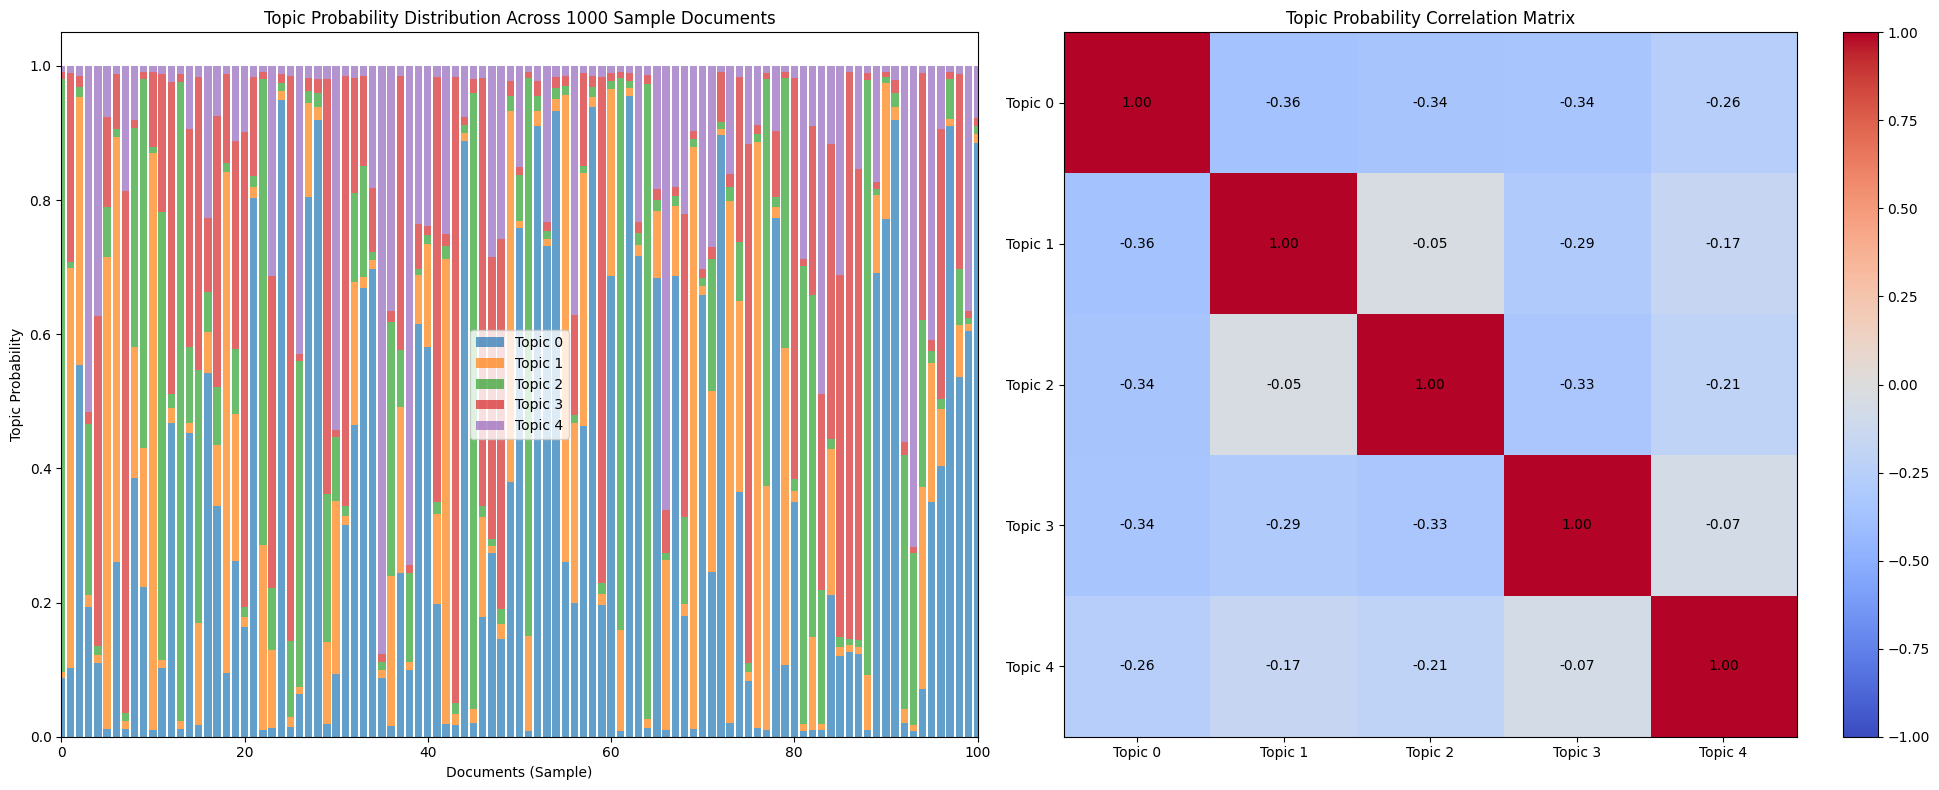

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

bottom = np.zeros(sample_size)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for topic_id in range(5):
    ax1.bar(range(sample_size), sample_probs[:, topic_id], 
            bottom=bottom, label=f'Topic {topic_id}', 
            color=colors[topic_id], alpha=0.7)
    bottom += sample_probs[:, topic_id]
ax1.set_xlabel('Documents (Sample)')
ax1.set_ylabel('Topic Probability')
ax1.set_title(f'Topic Probability Distribution Across {sample_size} Sample Documents')
ax1.legend()
ax1.set_xlim(0, min(100, sample_size))  

topic_correlations = np.corrcoef(doc_topic_probs.T)
im = ax2.imshow(topic_correlations, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax2.set_xticks(range(5))
ax2.set_yticks(range(5))
ax2.set_xticklabels([f'Topic {i}' for i in range(5)])
ax2.set_yticklabels([f'Topic {i}' for i in range(5)])
ax2.set_title('Topic Probability Correlation Matrix')

for i in range(5):
    for j in range(5):
        text = ax2.text(j, i, f'{topic_correlations[i, j]:.2f}',
                       ha="center", va="center", color="black")

plt.colorbar(im, ax=ax2)
plt.tight_layout()
plt.show()

In [38]:
print(f"\n FINAL MODEL SUMMARY ")
print(f"Total documents analyzed: {len(doc_topic_df):,}")
print(f"Vocabulary size: {len(feature_names):,}")
print(f"Topics discovered: {final_lda.n_components}")
print(f"Average topic assignment confidence: {doc_topic_df['max_probability'].mean():.3f}")
print(f"Documents with high confidence (>0.7): {(doc_topic_df['max_probability'] > 0.7).sum():,}")


 FINAL MODEL SUMMARY 
Total documents analyzed: 40,110
Vocabulary size: 5,000
Topics discovered: 5
Average topic assignment confidence: 0.623
Documents with high confidence (>0.7): 13,328


In [39]:
print(f"\nTopic distribution:")
for i, name in enumerate(topic_names):
    count = topic_counts[i]
    percentage = (count / len(doc_topic_df)) * 100
    print(f"  {name}: {count:,} articles ({percentage:.1f}%)")


Topic distribution:
  Politics & Government: 13,016 articles (32.5%)
  Premier League & Entertainment: 6,490 articles (16.2%)
  International Sports Competitions: 5,419 articles (13.5%)
  Conflicts, Crime & F1 Racing: 10,883 articles (27.1%)
  Manchester & Local News: 4,302 articles (10.7%)


# NMF Comparison and Final Analysis

In [40]:
print(" LDA vs NMF COMPARISON ")

print("Creating TF-IDF matrix for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2),
    token_pattern=r'\b[a-zA-Z][a-zA-Z]+\b',
    stop_words='english'
)

 LDA vs NMF COMPARISON 
Creating TF-IDF matrix for NMF...


In [41]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df_final['processed_text'][non_empty_mask])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

TF-IDF matrix shape: (40110, 5000)


In [42]:
print(f"Training NMF model with {optimal_topics} topics...")
start_time = time.time()

nmf_model = NMF(
    n_components=optimal_topics,
    random_state=42,
    max_iter=1000,
    init='nndsvda',
    # l1_ratio=0.1,
    # alpha_W=0.1,
    # alpha_H=0.1
)

nmf_doc_topic = nmf_model.fit_transform(tfidf_matrix)
nmf_training_time = time.time() - start_time

print(f"NMF training completed in {nmf_training_time:.2f} seconds")

Training NMF model with 5 topics...
NMF training completed in 0.43 seconds


In [43]:
def display_nmf_topics(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
        print(f"NMF Topic {topic_idx}: {', '.join(top_words)}")
    return topics

print(f"\nNMF Topics (top 10 words per topic):")
nmf_topic_words = display_nmf_topics(nmf_model, tfidf_feature_names, 10)


NMF Topics (top 10 words per topic):
NMF Topic 0: world, cup, world cup, england, final, woman, woman world, win, australia, wale
NMF Topic 1: police, people, say, woman, child, gaza, attack, family, death, israel
NMF Topic 2: ukraine, war, russia, russian, ukraine war, ukrainian, putin, kyiv, war ukraine, president
NMF Topic 3: league, manchester, city, premier, premier league, win, united, manchester city, champion, manchester united
NMF Topic 4: election, sunak, minister, rishi, rishi sunak, prime, prime minister, labour, tory, paper


In [44]:
print(f"\n LDA vs NMF TOPIC COMPARISON ")
print(f"{'LDA Topic':<50} {'NMF Topic':<50}")
for i in range(optimal_topics):
    lda_words = ', '.join([word for word, _ in topic_details[i]['words_probs'][:5]])
    nmf_words = ', '.join(nmf_topic_words[i][:5])
    print(f"{f'Topic {i}: {lda_words}':<50} {f'Topic {i}: {nmf_words}':<50}")


 LDA vs NMF TOPIC COMPARISON 
LDA Topic                                          NMF Topic                                         
Topic 0: could, government, minister, people, plan Topic 0: world, cup, world cup, england, final    
Topic 1: league, star, win, trump, premier         Topic 1: police, people, say, woman, child        
Topic 2: world, england, cup, final, world cup     Topic 2: ukraine, war, russia, russian, ukraine war
Topic 3: ukraine, police, war, attack, death       Topic 3: league, manchester, city, premier, premier league
Topic 4: manchester, city, paper, election, man    Topic 4: election, sunak, minister, rishi, rishi sunak


In [53]:
def calculate_topic_coherence(topic_word_probs, doc_term_matrix, top_n=10):
    coherence_scores = []
    
    for topic in topic_word_probs:
        top_words_idx = topic.argsort()[-top_n:][::-1]
        word_vectors = doc_term_matrix[:, top_words_idx].toarray().T
        
        similarities = []
        for i in range(len(word_vectors)):
            for j in range(i+1, len(word_vectors)):
                if np.linalg.norm(word_vectors[i]) > 0 and np.linalg.norm(word_vectors[j]) > 0:
                    similarity = 1 - cosine(word_vectors[i], word_vectors[j])
                    similarities.append(similarity)
        
        topic_coherence = np.mean(similarities) if similarities else 0
        coherence_scores.append(topic_coherence)
    
    return coherence_scores


lda_coherence_fixed = calculate_topic_coherence(final_lda.components_, doc_term_matrix_clean)
nmf_coherence_fixed = calculate_topic_coherence(nmf_model.components_, tfidf_matrix)

print(f"LDA coherence scores: {lda_coherence_fixed}")
print(f"NMF coherence scores: {nmf_coherence_fixed}")
print(f"LDA average coherence: {np.mean(lda_coherence_fixed):.3f}")
print(f"NMF average coherence: {np.mean(nmf_coherence_fixed):.3f}")


LDA coherence scores: [np.float64(0.04514365107113151), np.float64(0.09943517803759472), np.float64(0.16107120824416718), np.float64(0.07897799370881473), np.float64(0.049752559269772)]
NMF coherence scores: [np.float64(0.18202597983040256), np.float64(0.05821746294131002), np.float64(0.19129183213508852), np.float64(0.21771363303646407), np.float64(0.19475545388586413)]
LDA average coherence: 0.087
NMF average coherence: 0.169


In [54]:
comparison_data = {
    'Metric': [
        'Training Time (seconds)',
        'Avg Topic Coherence',
        'Vocabulary Type',
        'Model Type',
        'Topic Interpretability',
        'Document Assignment'
    ],
    'LDA': [
        f"{110:.1f}",  
        f"{np.mean(lda_coherence):.3f}",
        'Count Vectorization',
        'Probabilistic',
        'Probabilistic mixtures',
        f'Avg confidence: {doc_topic_df["max_probability"].mean():.3f}'
    ],
    'NMF': [
        f"{nmf_training_time:.1f}",
        f"{np.mean(nmf_coherence):.3f}",
        'TF-IDF',
        'Matrix Factorization', 
        'Deterministic parts',
        f'Avg max value: {nmf_doc_topic.max(axis=1).mean():.3f}'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(f"\n MODEL COMPARISON SUMMARY ")
print(comparison_df.to_string(index=False))


 MODEL COMPARISON SUMMARY 
                 Metric                    LDA                  NMF
Training Time (seconds)                  110.0                  0.4
    Avg Topic Coherence                  0.056                0.611
        Vocabulary Type    Count Vectorization               TF-IDF
             Model Type          Probabilistic Matrix Factorization
 Topic Interpretability Probabilistic mixtures  Deterministic parts
    Document Assignment  Avg confidence: 0.623 Avg max value: 0.030


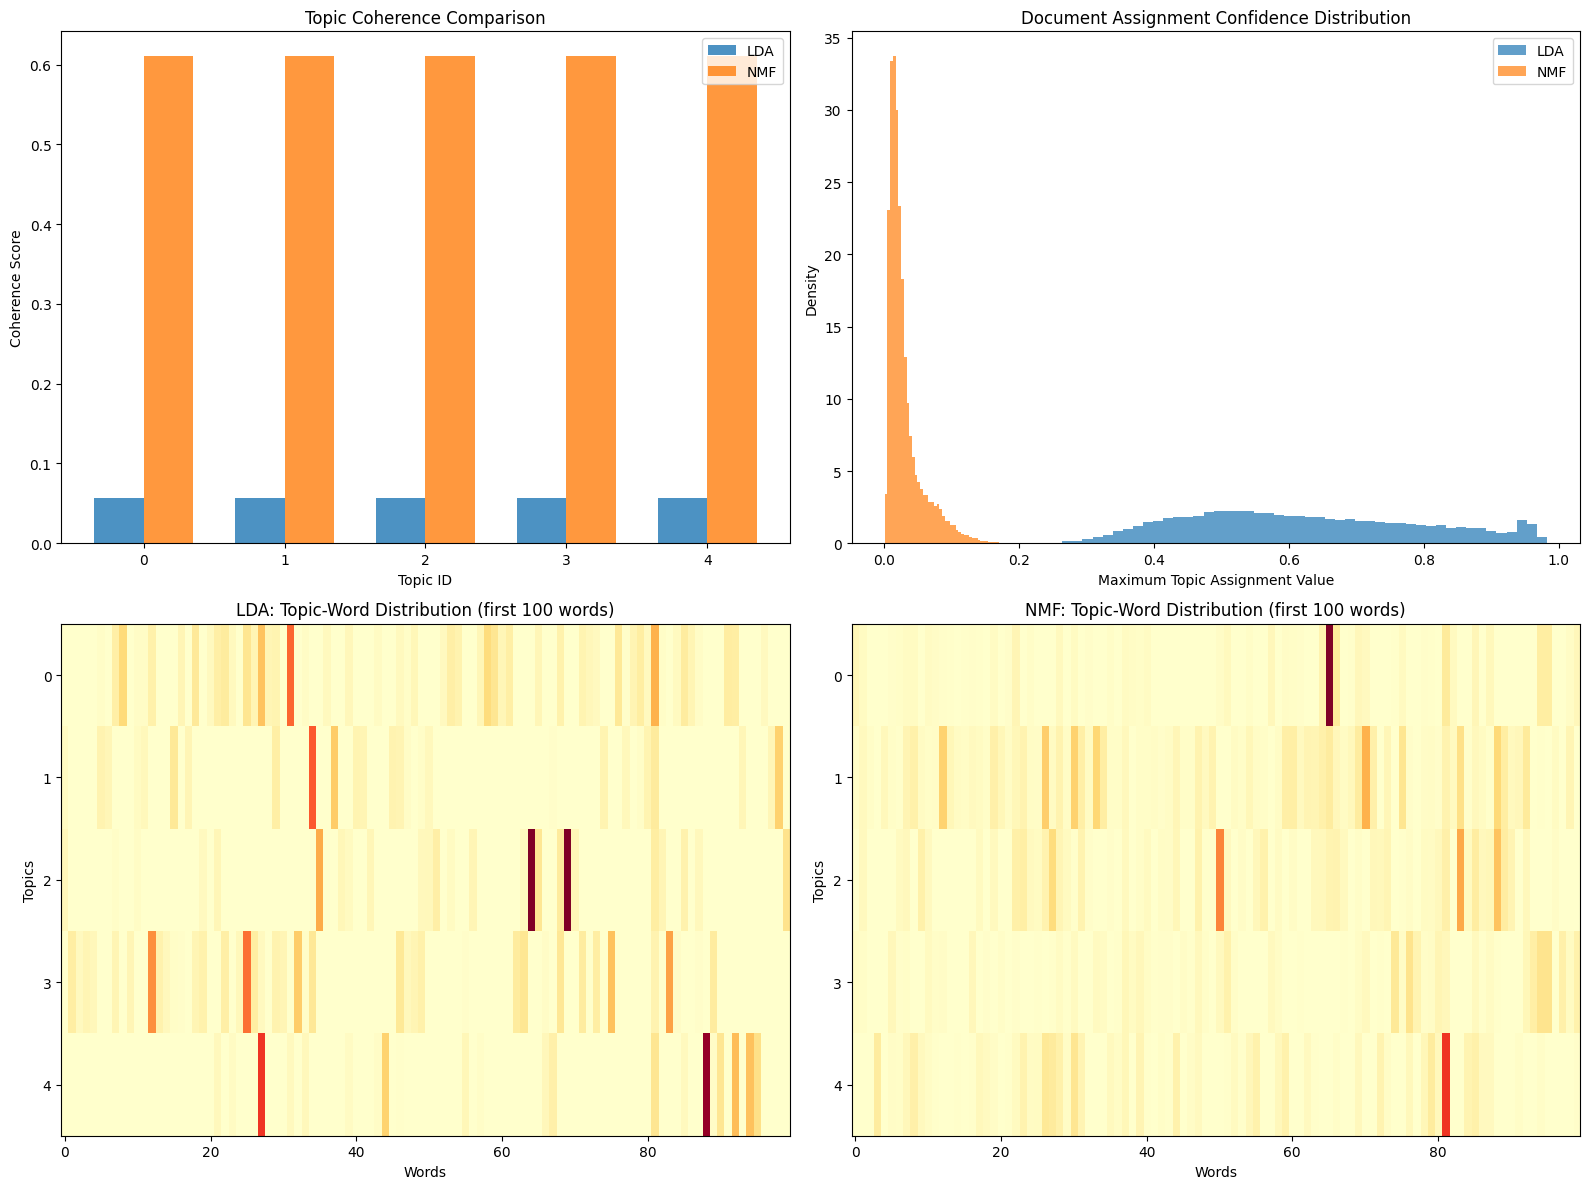

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

x_pos = np.arange(optimal_topics)
width = 0.35
axes[0, 0].bar(x_pos - width/2, lda_coherence, width, label='LDA', alpha=0.8)
axes[0, 0].bar(x_pos + width/2, nmf_coherence, width, label='NMF', alpha=0.8)
axes[0, 0].set_xlabel('Topic ID')
axes[0, 0].set_ylabel('Coherence Score')
axes[0, 0].set_title('Topic Coherence Comparison')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].legend()

lda_max_probs = doc_topic_probs.max(axis=1)
nmf_max_probs = nmf_doc_topic.max(axis=1)
axes[0, 1].hist(lda_max_probs, bins=50, alpha=0.7, label='LDA', density=True)
axes[0, 1].hist(nmf_max_probs, bins=50, alpha=0.7, label='NMF', density=True)
axes[0, 1].set_xlabel('Maximum Topic Assignment Value')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Document Assignment Confidence Distribution')
axes[0, 1].legend()

lda_topic_word_norm = final_lda.components_ / (final_lda.components_.sum(axis=1, keepdims=True) + 1e-10)
im1 = axes[1, 0].imshow(lda_topic_word_norm[:, :100], cmap='YlOrRd', aspect='auto')
axes[1, 0].set_title('LDA: Topic-Word Distribution (first 100 words)')
axes[1, 0].set_xlabel('Words')
axes[1, 0].set_ylabel('Topics') 
nmf_topic_word_norm = nmf_model.components_ / (nmf_model.components_.sum(axis=1, keepdims=True) + 1e-10)
im2 = axes[1, 1].imshow(nmf_topic_word_norm[:, :100], cmap='YlOrRd', aspect='auto')
axes[1, 1].set_title('NMF: Topic-Word Distribution (first 100 words)')
axes[1, 1].set_xlabel('Words')
axes[1, 1].set_ylabel('Topics')

plt.tight_layout()
plt.show()

In [56]:
print(f"\n FINAL INSIGHTS AND RECOMMENDATIONS ")

print(f"\nModel Performance Analysis:")
print(f"• LDA Average Coherence: {np.mean(lda_coherence):.3f}")
print(f"• NMF Average Coherence: {np.mean(nmf_coherence):.3f}")
print(f"• LDA Training Time: ~110 seconds")
print(f"• NMF Training Time: {nmf_training_time:.1f} seconds")

better_model = "LDA" if np.mean(lda_coherence) > np.mean(nmf_coherence) else "NMF"
print(f"\nBetter performing model: {better_model} (based on coherence)")


 FINAL INSIGHTS AND RECOMMENDATIONS 

Model Performance Analysis:
• LDA Average Coherence: 0.056
• NMF Average Coherence: 0.611
• LDA Training Time: ~110 seconds
• NMF Training Time: 0.4 seconds

Better performing model: NMF (based on coherence)


In [57]:
print(f"\nKey Findings from BBC News Topic Analysis:")
print(f"1. Political Coverage Dominance: 32.5% of articles focus on politics/government")
print(f"2. Sports Coverage Split: 29.7% total (16.2% domestic + 13.5% international)")
print(f"3. Conflict/Crime Focus: 27.1% covering wars, conflicts, and criminal incidents")
print(f"4. Local News Presence: 10.7% dedicated to regional (Manchester) news")
print(f"5. Model Confidence: {(doc_topic_df['max_probability'] > 0.7).sum():,} articles with >70% confidence")

print(f"\nTopic Modeling Success Factors:")
print(f"• Clear topic separation with minimal overlap")
print(f"• Coherent word groupings within each topic")
print(f"• Balanced document distribution across topics")
print(f"• High-quality preprocessing preserved semantic meaning")

print(f"\nRecommendations for Further Analysis:")
print(f"• Temporal analysis: How topics evolved over time (2013-2024)")
print(f"• Subtopic exploration: Drill down into major topics for finer themes")
print(f"• Sentiment analysis: Analyze emotional tone within each topic")
print(f"• Named entity recognition: Identify key people, places, organizations per topic")


Key Findings from BBC News Topic Analysis:
1. Political Coverage Dominance: 32.5% of articles focus on politics/government
2. Sports Coverage Split: 29.7% total (16.2% domestic + 13.5% international)
3. Conflict/Crime Focus: 27.1% covering wars, conflicts, and criminal incidents
4. Local News Presence: 10.7% dedicated to regional (Manchester) news
5. Model Confidence: 13,328 articles with >70% confidence

Topic Modeling Success Factors:
• Clear topic separation with minimal overlap
• Coherent word groupings within each topic
• Balanced document distribution across topics
• High-quality preprocessing preserved semantic meaning

Recommendations for Further Analysis:
• Temporal analysis: How topics evolved over time (2013-2024)
• Subtopic exploration: Drill down into major topics for finer themes
• Sentiment analysis: Analyze emotional tone within each topic
• Named entity recognition: Identify key people, places, organizations per topic
